In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import sklearn

sns.set(style="ticks", color_codes=True)
%matplotlib inline 

In [2]:
# read in data
def get_data(filename, headers = False, ind = None):
    if headers and ind:
        data_df = pd.read_csv(filename, header = 0, index_col = ind)
    elif headers and not ind:
        data_df = pd.read_csv(filename, header = 0)
    else:
         data_df = pd.read_csv(filename)
    return data_df

In [3]:
source = "/Users/lorenh/Documents/Classes/Spring Quarter 2018/Machine Learning for Public Policy/Homework Assignments/HW2/credit-data.csv"

In [4]:
credit_df = get_data(filename = source, headers = True, ind = 0)

In [5]:
credit_df = pd.read_csv(source, header = 0, index_col = 0)
credit_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [85]:
# explore statistics of all columns
credit_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000000,41016.00000,41016.000000,41016.000000,41016.000000,41016.000000,4.101600e+04,41016.000000,41016.000000,41016.000000,41016.000000,41016.000000
mean,0.161400,6.37587,51.683489,60623.824166,0.589233,331.458137,6.320623e+03,8.403477,0.419592,1.008801,0.371587,0.753681
std,0.367904,221.61895,14.746880,11.984357,5.205628,1296.109695,1.208056e+04,5.207324,5.190382,1.153826,5.169641,1.113639
min,0.000000,0.00000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.03431,41.000000,60618.000000,0.000000,0.176375,3.800000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.18973,51.000000,60625.000000,0.000000,0.369736,5.250000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.66716,62.000000,60629.000000,0.000000,0.866471,7.245500e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,22000.00000,109.000000,60644.000000,98.000000,106885.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


In [6]:
# Null frequency tabulation for each column
# Attribution: https://github.com/yhat/DataGotham2013/blob/master/analysis/main.py
def print_null_freq(df):
    """
    for a given DataFrame, calculates how many values for each variable is null
    and prints the resulting table to stdout
    """
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(pd.crosstab(df_lng.variable, null_variables))


In [7]:
copy_df = credit_df

In [8]:
print_null_freq(copy_df)

value                                 False  True 
variable                                          
DebtRatio                             41016      0
MonthlyIncome                         33042   7974
NumberOfDependents                    39979   1037
NumberOfOpenCreditLinesAndLoans       41016      0
NumberOfTime30-59DaysPastDueNotWorse  41016      0
NumberOfTime60-89DaysPastDueNotWorse  41016      0
NumberOfTimes90DaysLate               41016      0
NumberRealEstateLoansOrLines          41016      0
RevolvingUtilizationOfUnsecuredLines  41016      0
SeriousDlqin2yrs                      41016      0
age                                   41016      0
zipcode                               41016      0


In [18]:
def basic_fill_vals(df, col_name, method = None):
    if method == "zeros":
        df[col_name] = df[col_name].fillna(0)
    elif method == "mean":
        replacement_val = df[col_name].median()
        df[col_name] = df[col_name].fillna(replacement_val)
    elif method == "mean":
        replacement_val = df[col_name].mean()
        df[col_name] = df[col_name].fillna(replacement_val)

In [ ]:
# fill null values  with basic 
basic_fill_vals(copy_df, "NumberOfDependents", method = "zeros")

In [16]:
basic_fill_vals(copy_df, "MonthlyIncome", method = "mean")

In [17]:
print_null_freq(copy_df)

value                                 False
variable                                   
DebtRatio                             41016
MonthlyIncome                         41016
NumberOfDependents                    41016
NumberOfOpenCreditLinesAndLoans       41016
NumberOfTime30-59DaysPastDueNotWorse  41016
NumberOfTime60-89DaysPastDueNotWorse  41016
NumberOfTimes90DaysLate               41016
NumberRealEstateLoansOrLines          41016
RevolvingUtilizationOfUnsecuredLines  41016
SeriousDlqin2yrs                      41016
age                                   41016
zipcode                               41016


In [81]:
# develop quick check of column position via dictionary
def create_col_ref(df):
    col_list = df.columns
    col_dict = {}
    for list_position, col_name in enumerate(col_list):
        col_dict[col_name] = list_position
    return col_dict

In [82]:
col_ref = create_col_ref(credit_df)
print(col_ref)

{'SeriousDlqin2yrs': 0, 'RevolvingUtilizationOfUnsecuredLines': 1, 'age': 2, 'zipcode': 3, 'NumberOfTime30-59DaysPastDueNotWorse': 4, 'DebtRatio': 5, 'MonthlyIncome': 6, 'NumberOfOpenCreditLinesAndLoans': 7, 'NumberOfTimes90DaysLate': 8, 'NumberRealEstateLoansOrLines': 9, 'NumberOfTime60-89DaysPastDueNotWorse': 10, 'NumberOfDependents': 11}


In [79]:
# view distributions of features
def view_dist(df, categoricals_list):
    print("Feature Distributions")
    df.drop(categoricals_list, axis = 1).hist(bins = 50, figsize=(20,15), color = 'red')
    plt.show()

Feature Distributions


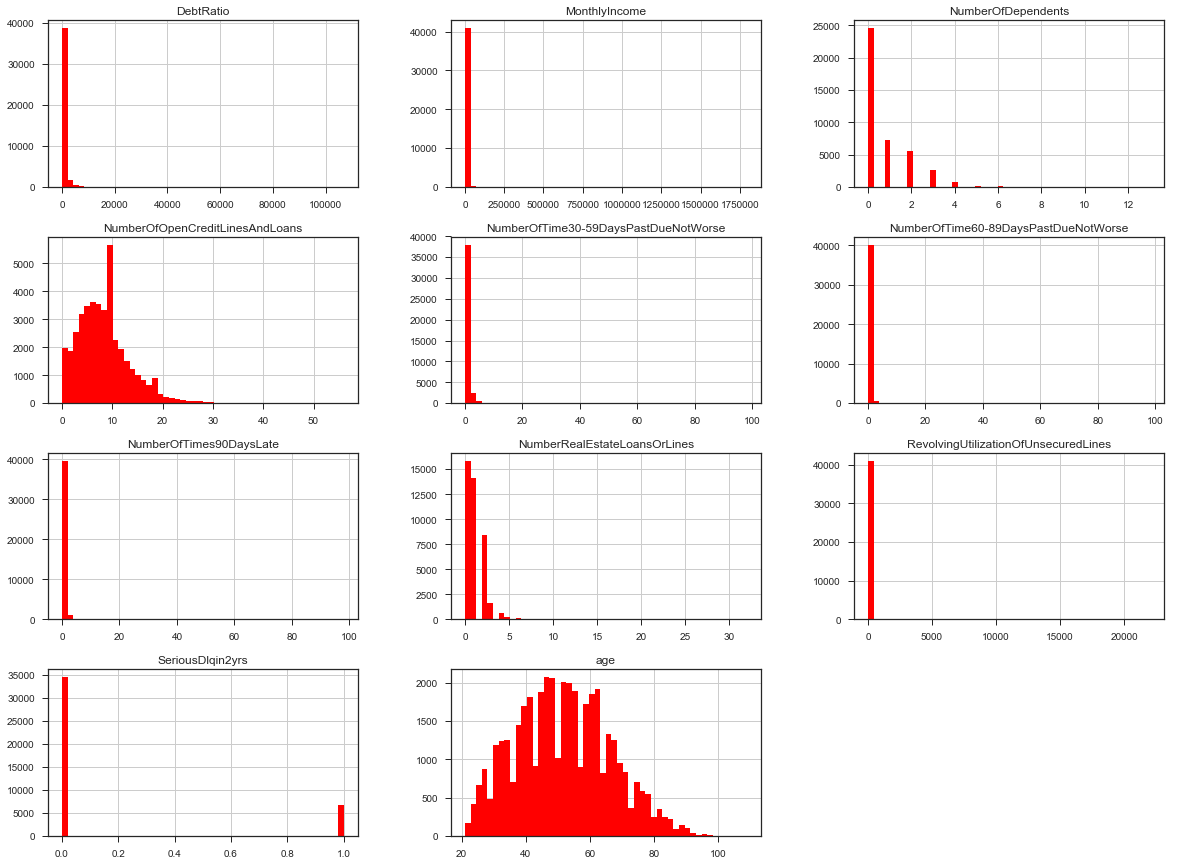

In [80]:
view_dist(copy_df, ["zipcode"])

In [98]:
# Check linear correlation between non-categorical variables
# Attribution: https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials

def check_corr(df, categorical_list)
    df.drop(categorical_list, axis = 1).corr(method="pearson").style.format("{:.2}").background_gradient(cmap=plt.get_cmap("coolwarm"), axis = 1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.0,-0.0046,-0.17,0.15,-0.014,-0.033,-0.04,0.14,-0.011,0.12,0.066
RevolvingUtilizationOfUnsecuredLines,-0.0046,1.0,-0.008,-0.002,0.022,0.0058,-0.015,-0.0017,0.0048,-0.0014,0.0053
age,-0.17,-0.008,1.0,-0.069,0.039,0.048,0.16,-0.069,0.049,-0.064,-0.21
NumberOfTime30-59DaysPastDueNotWorse,0.15,-0.002,-0.069,1.0,-0.012,-0.015,-0.071,0.98,-0.038,0.99,-0.0078
DebtRatio,-0.014,0.022,0.039,-0.012,1.0,-0.023,0.083,-0.015,0.18,-0.013,-0.071
MonthlyIncome,-0.033,0.0058,0.048,-0.015,-0.023,1.0,0.11,-0.018,0.13,-0.015,0.061
NumberOfOpenCreditLinesAndLoans,-0.04,-0.015,0.16,-0.071,0.083,0.11,1.0,-0.098,0.44,-0.087,0.06
NumberOfTimes90DaysLate,0.14,-0.0017,-0.069,0.98,-0.015,-0.018,-0.098,1.0,-0.055,0.99,-0.016
NumberRealEstateLoansOrLines,-0.011,0.0048,0.049,-0.038,0.18,0.13,0.44,-0.055,1.0,-0.048,0.11
NumberOfTime60-89DaysPastDueNotWorse,0.12,-0.0014,-0.064,0.99,-0.013,-0.015,-0.087,0.99,-0.048,1.0,-0.016


In [65]:
# observe distributions and correlations of features 
def plot_corr(df, categoricals_list):
    corr = sns.pairplot(df.drop(categoricals_list, axis = 1))

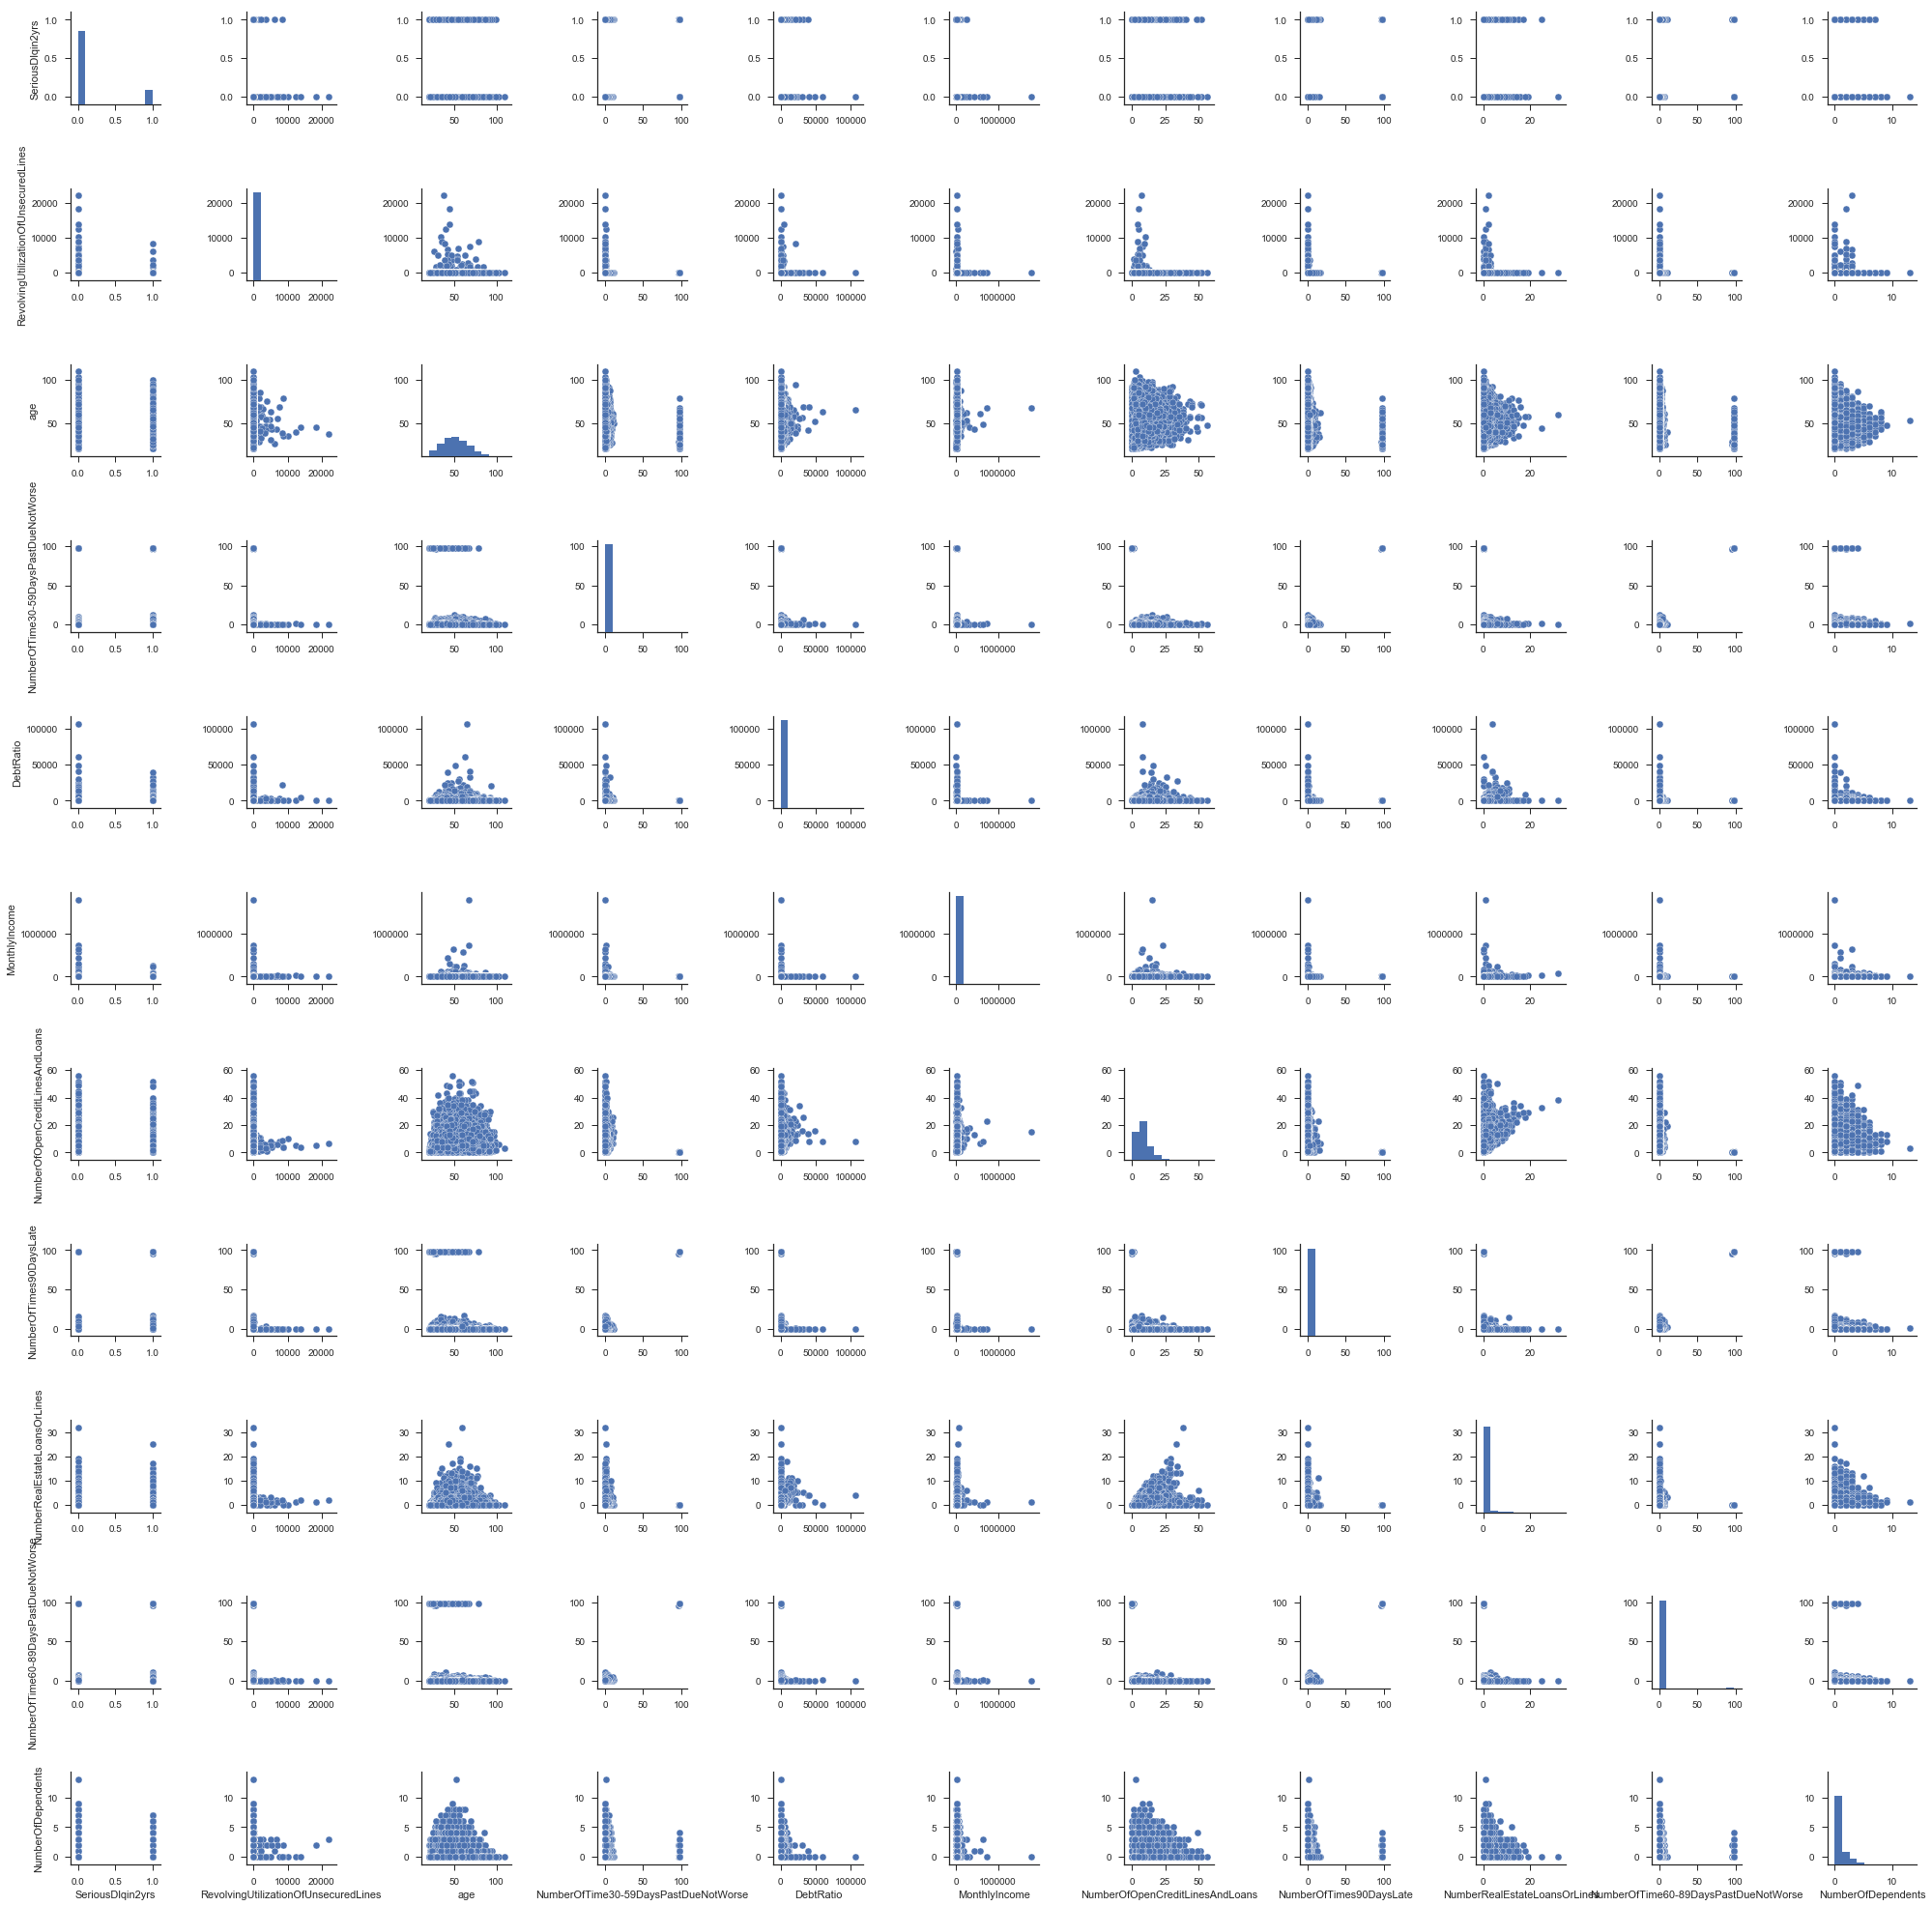

In [66]:
plot_corr(copy_df, ["zipcode"])

In [22]:
copy_df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'],
      dtype='object')

In [92]:
def discretize_cols(df, cols_to_bin, num_bins, bin_labels):
    for col in cols_to_bin:
        bin_col = col + "_bin"
        df[bin_col] = pd.qcut(df[col], q = num_bins, labels = bin_labels, precision=3, duplicates='drop')


In [93]:
discretize_cols(df = copy_df.dropna(), cols_to_bin = ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 
                                                      'age','NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                                                       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                                                       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                                                       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']], 
                num_bins = 3, bin_labels = ["low", "mid", "high"])

In [94]:
copy_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin
PersonID,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0,mid
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0,high
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0,mid
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0,mid
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0,mid


In [ ]:
def feature_by_geo(df, geo, expl_var, num_var):
    
    df_geo = df[(df[geo] != 0) & (df[geo] != '') & (df[geo] != '0')]
    geo_requests = df_geo.groupby([geo, expl_var])[num_var].count().unstack(expl_var)
    for val in df[expl_var].unique():
        pct_col_name = "% of " + val
        geo_requests[pct_col_name] = (geo_requests[val] / geo_requests[val].sum() * 100)
    # geo_requests = geo_requests.drop(['Alley Light Out', 'Graffiti Removal', 'Vacant/Abandoned Building'], axis = 1)
    geo_requests.fillna(value = 0, inplace = True)
    return geo_requests

geo_req_data = requests_by_geo(copy_df, 'zipcode')

In [86]:
copy_df['age'].unique()

array([ 55,  71,  51,  45,  57,  48,  34,  30,  50,  26,  64,  61,  39,
        66,  32,  76,  73,  41,  60,  43,  56,  63,  72,  67,  35,  47,
        49,  52,  62,  70,  33,  24,  40,  54,  79,  69,  28,  83,  37,
        75,  78,  59,  65,  42,  80,  44,  27,  58,  53,  38,  77,  46,
        74,  81,  36,  21,  23,  29,  84,  91,  68,  85,  22,  90,  31,
        25,  87,  89,  88,  82,  86,  92,  97,  94, 103,  95,  96,  93,
        99,  98, 109])